In [1]:
import sys

sys.path.append('../GraphStructureLearning')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import yaml
from easydict import EasyDict as edict
import pickle
import torch
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils.utils import build_fully_connected_edge_idx

from torch_geometric.utils import to_dense_adj, is_undirected

In [3]:
def mkdir(folder):
      if not os.path.isdir(folder):
        os.makedirs(folder)

In [4]:
def plot_adj(inf_adj, target, save, dirs=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25.6, 18.0))

    title = 'Adjacency Matrix'

    axes[0].imshow(inf_adj, cmap='Greys', vmin=0, vmax=1)
    axes[0].set_title('Learned Adj Matrix\n', fontsize = 20)
    axes[0].set_xlabel('Node index', fontsize = 20)
    axes[0].set_ylabel('Node index', fontsize = 20)

    axes[1].imshow(target, cmap='Greys', vmin=0, vmax=1)
    axes[1].set_title('Target\n', fontsize = 20)
    axes[1].set_xlabel('Node index', fontsize = 20)
    axes[1].set_ylabel('Node index', fontsize = 20)

    div_0 = make_axes_locatable(axes[0])
    div_1 = make_axes_locatable(axes[1])
    cax_0 = div_0.append_axes("right", size="5%", pad=0.05)
    cax_1 = div_1.append_axes("right", size="5%", pad=0.05)
    cax_0.tick_params(axis='both', labelsize=20)
    cax_1.tick_params(axis='both', labelsize=20)

    fig.colorbar(axes[0].imshow(inf_adj, cmap='hot'), cax=cax_0)
    fig.colorbar(axes[1].imshow(target, cmap='hot'), cax=cax_1)

    fig.suptitle(title, fontsize = 40)
    axes[0].tick_params(axis='both', labelsize=20)
    axes[1].tick_params(axis='both', labelsize=20)
    
    if save:
        fig.savefig(dirs+'/adj_matrix.png')

    fig.show()

In [5]:
def plot_leanring_result(train_loss, val_loss, val_adj_matrix, save, dirs=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

    axes[0].plot(train_loss, lw=1, label='Training Loss')
    axes[0].plot(val_loss, lw=1, label='Validation Loss')
    
    axes[0].legend()
    
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Poisson Loss')
    
    edge_num_list = []
    for i in range(len(val_adj_matrix)):
        training_adj = val_adj_matrix[i]
        _adj = to_dense_adj(torch.LongTensor(training_adj))[0]

        edge_num = int(torch.sum(_adj) / 2)

        edge_num_list.append(edge_num)
            
    axes[1].plot(edge_num_list, lw=1, label='edge num')
    
    axes[1].legend()
    axes[1].set_title("Total Connection epoch_by_epoch")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Connection')
        
    if save:
        fig.savefig(dirs+'/learning_result.png')
    
    fig.show()

In [6]:
def plot_spike(pred, target, num, save, dirs):
    fig, axes = plt.subplots(nrows=num, ncols=2, figsize=(17,15))
    
    for ii in range(num):
        _pred = pred[ii]
        _target = target[ii]
        
        spike_pred = torch.poisson(_pred.exp())
        spike_target = torch.poisson(_target.exp())
        
        im_o = axes[ii,0].imshow(spike_pred, cmap='binary')
        axes[ii,0].set_xlabel('Time')
        axes[ii,0].set_ylabel('Node index')
    
        im_t = axes[ii,1].imshow(spike_target, cmap='binary')
        axes[ii,1].set_xlabel('Time')
        axes[ii,1].set_ylabel('Node index')
        
        if ii == 0:
            axes[ii,0].set_title('Prediction\n')
            axes[ii,1].set_title('Target\n')
            
        if spike_pred.shape[1] < 20:
            axes[ii, 0].xaxis.set_visible(False)
            axes[ii, 1].xaxis.set_visible(False)

        
    fig.suptitle("Spike Visualization")
        
    if save:
        fig.savefig(dirs+'/spike_visual.png')
    
    fig.show()

In [7]:
def plot_edge_num_by_epoch(val_adj_matrix, save, dirs):
    edge_num_list = []

    for i in range(len(val_adj_matrix)):
        training_adj = val_adj_matrix[i]
        _adj = to_dense_adj(torch.LongTensor(training_adj))[0]

        edge_num = int(torch.sum(_adj) / 2)

        edge_num_list.append(edge_num)
        
    fig, axes = plt.subplots(figsize=(7,5))
    
    axes.plot(edge_num_list, lw=1, label='edge num')
    
    axes.legend()
    axes.set_title("Total Connection epoch_by_epoch")
    axes.set_xlabel('Epoch')
    axes.set_ylabel('Connection')
    
    if save:
        fig.savefig(dirs+'/connection_epoch_by_epoch.png')
    
    fig.show()

In [8]:
def plot_w_single(mat, tar, w_hat_std, nodes, mode_cplt, suffix):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
    idx_num = int(nodes/2)
    w_hat_plot = np.roll(mat, idx_num)
    w_tar_plot = np.roll(tar, idx_num)
    w_hat_plot[idx_num] = None
    w_tar_plot[idx_num] = None
    x = np.arange(nodes)
    axes.plot(w_hat_plot, color='royalblue', label='W_hat(single neuron)', alpha=0.7)
    axes.plot(w_tar_plot, color='darkorange', label='Target')
    if mode_cplt:
        axes.fill_between(x, w_hat_plot - w_hat_std, w_hat_plot + w_hat_std,
                        color='royalblue', label='1 sigma range', alpha=0.2)
    axes.tick_params(axis='x', labelsize=10)
    axes.tick_params(axis='y', labelsize=10)
    axes.tick_params(axis='x', labelsize=10)
    axes.tick_params(axis='y', labelsize=10)
    plt.legend(loc=3, prop={'size': 8})
#     plt.savefig('./fig/w_hat_single_{}.png'.format(suffix), bbox_inches='tight')

In [9]:
ground_truth_adj = np.load('./data/connectivity_W100.npy')

In [36]:
exp_dirs = glob('./exp/*')
exp_dirs.sort()
exp_dirs

['./exp\\GTS_1_0118_012100',
 './exp\\GTS_1_0118_012158',
 './exp\\GTS_1_0118_012607',
 './exp\\GTS_1_0118_015332',
 './exp\\GTS_1_0118_015354',
 './exp\\GTS_1_0118_015545']

In [37]:
save = False

for exp in exp_dirs[-1:]:
    config_file = glob(exp+'/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    
    train_result_dirs = glob(exp+'/training_result.pickle')
    train_result = pickle.load(open(train_result_dirs[0], 'rb'))
    
    test_result_dirs = glob(exp+'/test_result.pickle')
    test_result = pickle.load(open(test_result_dirs[0], 'rb'))
    
#     inf_adj = to_dense_adj(torch.LongTensor(test_result['adj_matrix']))[0]
    
#     exp_title = f'window:{config.dataset.window_size} slide,pred_step:{config.dataset.slide}'
#     _dirs = './visualize/'+exp_title
#     mkdir(_dirs)
    
#     pred = test_result['prediction'][0].view(-1, 100, config.dataset.slide*3)
#     target = test_result['target'][0].view(-1, 100, config.dataset.slide*3)
    
#     plot_leanring_result(train_result['train_loss'], train_result['val_loss'], train_result['val_adj_matirix'], save, dirs=_dirs)
#     plot_adj(inf_adj*-1, ground_truth_adj, save, dirs=_dirs)
#     plot_spike(pred, target, 3, save, dirs=_dirs)
#     plot_edge_num_by_epoch(train_result['val_adj_matirix'], save, dirs=_dirs)

In [38]:
weight_matrix = test_result['adj_matrix']['weight_matrix']

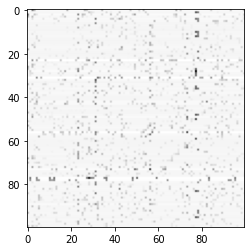

In [39]:
plt.imshow(weight_matrix, cmap='Greys')

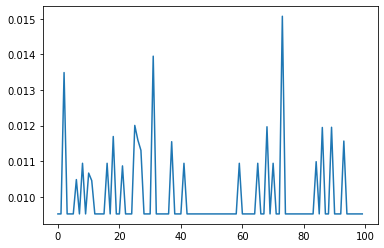

In [40]:
plt.plot(weight_matrix[49,:])

In [41]:
weight_matrix[49,:].sum()

tensor(1.)

In [42]:
adj_matrix = test_result['adj_matrix']['adj_matrix']

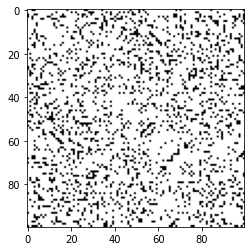

In [43]:
plt.imshow(adj_matrix, cmap='Greys')

In [29]:
adj_matrix.sum()

tensor(1926.)